# Multi-label learning

## Exploratory Data Analysis

In [1]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rc('font', size=12)

In [2]:
def load_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
dataset_folder = '../datasets/TMDB_5000/'

os.listdir(dataset_folder)

['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']

In [4]:
df_movies = load_movies(dataset_folder + 'tmdb_5000_movies.csv')

columns_of_interest = ['id', 'title', 'genres', 'overview']
df_movies = df_movies[columns_of_interest]
df_movies = df_movies[df_movies['genres'].str.len() != 0]
df_movies = df_movies[df_movies['overview'].notnull()].reset_index(drop=True)

df_movies.head()

,id,title,genres,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Following the death of District Attorney Harve...
4,49529,John Carter,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","John Carter is a war-weary, former military ca..."


In [5]:
genres_count = {}

for index, row in df_movies.iterrows():
    for genre in row['genres']:
        genre_name = genre['name']
        genres_count[genre_name] = genres_count[genre_name] + 1 if genre_name in genres_count else 1
        
genres_count = dict(sorted(genres_count.items(), key=lambda x:x[1], reverse=False))

In [6]:
genres_count

{'TV Movie': 8,
 'Foreign': 34,
 'Western': 82,
 'Documentary': 108,
 'War': 144,
 'Music': 185,
 'History': 197,
 'Animation': 234,
 'Mystery': 348,
 'Fantasy': 424,
 'Family': 513,
 'Horror': 519,
 'Science Fiction': 535,
 'Crime': 696,
 'Adventure': 790,
 'Romance': 894,
 'Action': 1154,
 'Thriller': 1274,
 'Comedy': 1722,
 'Drama': 2296}

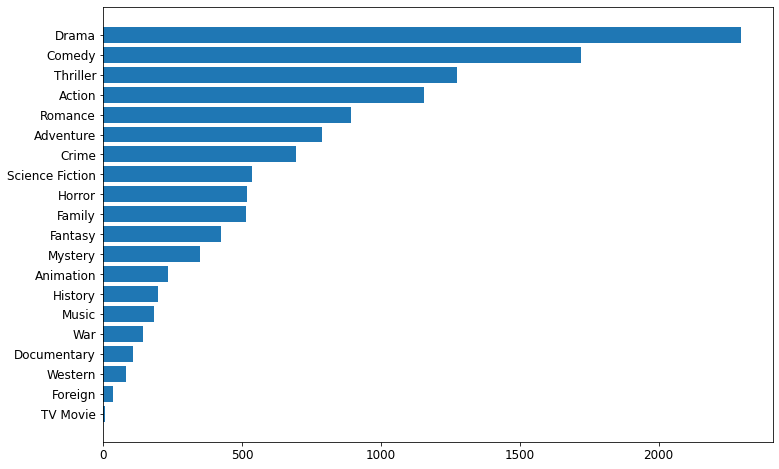

In [7]:
plt.figure(figsize=(12,8))
plt.barh(list(genres_count.keys()), genres_count.values())
plt.show()

## Data Preprocessing

### Tokenization

In [8]:
import gensim
import nltk

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ceyx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def tokenize(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(lemmatizer.lemmatize(token,'v')))
    return result

In [10]:
movie = df_movies.loc[255]
movie, movie['overview']

(id                                                      13700
 title                                       Home on the Range
 genres      [{'id': 16, 'name': 'Animation'}, {'id': 10751...
 overview    When a greedy outlaw schemes to take possessio...
 Name: 255, dtype: object,
 'When a greedy outlaw schemes to take possession of the "Patch Of Heaven" dairy farm, three determined cows, a karate-kicking stallion and a colorful corral of critters join forces to save their home. The stakes are sky-high as this unlikely animal alliance risk their hides and match wits with a mysterious band of bad guys.')

In [11]:
tokenize(movie['overview'])

['greedi',
 'outlaw',
 'scheme',
 'possess',
 'patch',
 'heaven',
 'dairi',
 'farm',
 'determin',
 'cow',
 'karat',
 'kick',
 'stallion',
 'color',
 'corral',
 'critter',
 'join',
 'forc',
 'save',
 'home',
 'stake',
 'high',
 'unlik',
 'anim',
 'allianc',
 'risk',
 'hide',
 'match',
 'wit',
 'mysteri',
 'band',
 'guy']

In [12]:
movie_overviews = df_movies['overview'].map(tokenize)
movie_overviews

0       [centuri, parapleg, marin, dispatch, moon, pan...
1       [captain, barbossa, long, believ, dead, come, ...
2       [cryptic, messag, bond, past, send, trail, unc...
3       [follow, death, district, attorney, harvey, de...
4       [john, carter, weari, militari, captain, inexp...
                              ...                        
4767    [adam, secur, guard, travel, california, phili...
4768    [mariachi, want, play, guitar, carri, famili, ...
4769    [newlyw, coupl, honeymoon, upend, arriv, respe...
4770    [sign, seal, deliv, introduc, dedic, quartet, ...
4771    [second, grade, brian, herzling, crush, draw, ...
Name: overview, Length: 4772, dtype: object

### Bag-of-Words & TfIdf

In [13]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

In [14]:
dictionary = Dictionary(movie_overviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in movie_overviews]
bow_corpus[255]

[(26, 1),
 (57, 1),
 (113, 1),
 (129, 1),
 (132, 1),
 (199, 1),
 (226, 1),
 (235, 1),
 (241, 1),
 (288, 1),
 (319, 1),
 (450, 1),
 (471, 1),
 (509, 1),
 (536, 1),
 (566, 1),
 (775, 1),
 (1173, 1),
 (1297, 1),
 (1341, 1),
 (1435, 1),
 (1436, 1),
 (1437, 1),
 (1438, 1)]

In [16]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]
tfidf_corpus = corpus2dense(tfidf_corpus, num_terms=100000, num_docs=len(tfidf_corpus)).T
tfidf_corpus.shape

(4772, 100000)

## Multi-label genre overview classification

### Binary relevance - Baseline

In [21]:
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn import metrics

In [22]:
genres = list(reversed(list(genres_count)))

x, y = [], []
for index, row in df_movies.iterrows():
    x.append(tfidf_corpus[index])
    ohe = np.zeros(len(genres))
    y_indices = [genres.index(genre['name']) for genre in row['genres']]
    ohe[y_indices] = 1
    y.append(ohe)
y = np.matrix(y)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
len(y_train), len(y_test)

(4056, 716)

In [24]:
def get_class_prob(model, sample):
    probs = model.predict_proba([sample]).T
    classes = model.classes_
    
    output = pd.DataFrame(data=[classes, probs]).T
    output.columns = ['genre', 'probability']
    output['probability'] = output.apply(lambda x: x['probability'][0], axis=1)
    return output.sort_values(by='probability', ascending=False)

In [26]:
clf = MultiOutputClassifier(GaussianNB()).fit(x_train, y_train)
dump(clf, 'multioutput_naivebayes.model')

['multioutput_naivebayes.model']

In [27]:
clf = load('multioutput_naivebayes.model')

In [28]:
y_test_predicted = clf.predict(x_test)

In [29]:
print('Hamming:', metrics.hamming_loss(y_test, y_test_predicted))
print('Accuracy:', metrics.accuracy_score(y_test, y_test_predicted))
print('Precision:', metrics.precision_score(y_test, y_test_predicted, average='samples'))
print('Recall:', metrics.recall_score(y_test, y_test_predicted, average='samples'))
print('F1:', metrics.f1_score(y_test, y_test_predicted, average='samples'))

Hamming: 0.2108240223463687
Accuracy: 0.018156424581005588
Precision: 0.36211723929847495
Recall: 0.6274740622505987
F1: 0.4155049388392307


d:\anaconda3\envs\multilearn\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random K-Labelsets

In [30]:
from skmultilearn.ensemble import RakelD

In [36]:
clf = RakelD(GaussianNB()).fit(x_train, y_train)
dump(clf, 'rakel_naivebayes.model')

d:\anaconda3\envs\multilearn\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


['rakel_naivebayes.model']

In [37]:
clf = load('rakel_naivebayes.model')

In [38]:
y_test_predicted = clf.predict(x_test)

In [39]:
print('Hamming:', metrics.hamming_loss(y_test, y_test_predicted))
print('Accuracy:', metrics.accuracy_score(y_test, y_test_predicted))
print('Precision:', metrics.precision_score(y_test, y_test_predicted, average='samples'))
print('Recall:', metrics.recall_score(y_test, y_test_predicted, average='samples'))
print('F1:', metrics.f1_score(y_test, y_test_predicted, average='samples'))

Hamming: 0.16801675977653632
Accuracy: 0.02653631284916201
Precision: 0.40137291712012385
Recall: 0.5397845171588188
F1: 0.42223552363217165


d:\anaconda3\envs\multilearn\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!